# Behavioral Analysis

This notebook analyze the behavioral performance of individual sessions.

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import sem, ttest_ind

from convnwb.paths import Paths
from convnwb.io import load_nwbfile, load_matfile, get_files

from spiketools.plts.utils import make_axes, save_figure
from spiketools.plts.data import plot_bar, plot_hist
from spiketools.plts.style import drop_spines
from spiketools.utils.base import count_elements

In [3]:
import sys
sys.path.append('../code')
from utils import compute_recall_percent, get_confidence_response

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
# Set data path for unit results
results_path = Path('../results/units/all/')

In [6]:
# Define the base data folder
nwb_path = '/data12/jacobs_lab/WVTH/nwb'
#nwb_path = '/Users/tom/Data/JacobsLab/WVTH/nwb'
#nwb_path = '/Users/clairehan/Documents/Data/JacobsLab/WVTH/NWB'

In [7]:
# Set project paths
project_path = '/data12/jacobs_lab/WVTH/'
paths = Paths(project_path)

In [8]:
# Set the path to the one-back behavioral data file
#nback_path = '/Users/clairehan/Desktop/research/WVTH/'
#nback_path = '/Users/tom/Documents/Research/2-Projects/1b-Current(Jacobs)/TH/zRESULTS/'
nback_path = paths.info / 'nback'

### Plot Settings

In [9]:
# Plot colors
colors = {
    'all' : 'silver',
    'face' : '#0F7AC0',
    'obj' : '#D95319',  
}

In [10]:
# Plot save settings
SAVE_FIG = False
SAVE_PATH = '/Users/clairehan/Desktop/paper_fig'
SAVE_FTYPE = '.svg'

## Behavioral Analyses

### Load data

In [11]:
# Get the list of NWB files running THO, THF respectively
nwbfiles_thf = get_files(nwb_path, select='THF')
nwbfiles_tho = get_files(nwb_path, select='THO')

In [12]:
# Load the one-back behavioral data results
nback_filename = 'behAcc.mat'
behav_nback = load_matfile(nback_filename, nback_path)

### Recall correctness

In [13]:
# Collect OB performance 
correct_obf = (behav_nback['AccCel'][0]) * 100
correct_obo = (behav_nback['AccImg'][0]) * 100

In [14]:
# Compute the percentage of recall for all data, and for each task
correct_thf = compute_recall_percent(nwbfiles_thf, nwb_path)
correct_tho = compute_recall_percent(nwbfiles_tho, nwb_path)

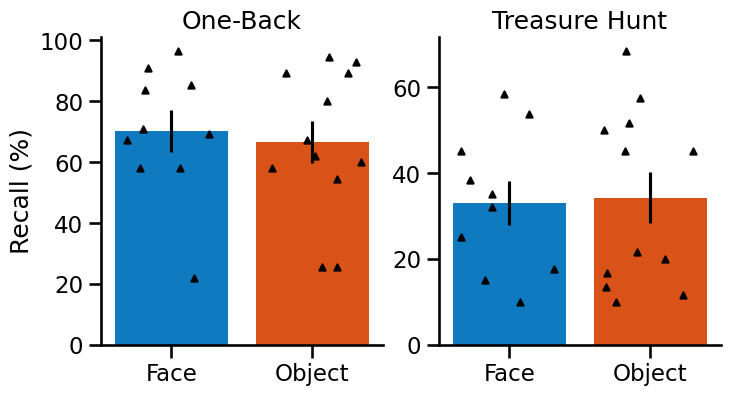

In [15]:
# Plot the accuracy of each task
ax1, ax2 = make_axes(2, 2, figsize=(8,4))
plot_bar([correct_obf.mean(0), correct_obo.mean(0)], ['Face', 'Object'],
         ylabel='Recall (%)', title='One-Back', yerr=[sem(correct_obf, 0), sem(correct_obo, 0)], 
         zorder=0, color=[colors['face'], colors['obj']], ax=ax1)
plot_bar([correct_thf.mean(0), correct_tho.mean(0)], ['Face', 'Object'],
         title='Treasure Hunt', yerr=[sem(correct_thf, 0), sem(correct_tho, 0)], 
         color=[colors['face'], colors['obj']], zorder=0, ax=ax2)
ww = 0.7
for ii, (ob_data, th_data) in enumerate(zip([correct_obf, correct_obo], [correct_thf, correct_tho])):
    ax1.scatter(ii + np.random.random(ob_data.size) * ww - ww / 2, ob_data, color='black', marker='^', s=20)
    ax2.scatter(ii + np.random.random(th_data.size) * ww - ww / 2, th_data, color='black', marker='^', s=20)
for cax in [ax1, ax2]:
    drop_spines(['top', 'right'], cax)
if SAVE_FIG:
    save_figure('behav' + SAVE_FTYPE, SAVE_PATH, bbox_inches='tight')

### Check Average Values

In [16]:
print('# face sessions:  ', len(correct_obf), len(correct_thf))
print('# obj  sessions:  ', len(correct_obo), len(correct_tho))

# face sessions:   10 10
# obj  sessions:   12 12


In [17]:
print('Average performance, OBF: \t{:4.2f}%'.format(np.mean(correct_obf)))
print('Average performance, OBO: \t{:4.2f}%'.format(np.mean(correct_obo)))

Average performance, OBF: 	70.18%
Average performance, OBO: 	66.52%


In [18]:
print('Average performance, THF: \t{:4.2f}%'.format(np.mean(correct_thf)))
print('Average performance, THO: \t{:4.2f}%'.format(np.mean(correct_tho)))

Average performance, THF: 	33.01%
Average performance, THO: 	34.24%


### Statistically Compare Task Versions

In [19]:
# Check for OB differences between face / object
ob_perf = ttest_ind(correct_obf, correct_obo)
ob_perf

Ttest_indResult(statistic=0.37391397229132567, pvalue=0.7124028807478401)

In [20]:
# Check for TH differences between face / object
th_perf = ttest_ind(correct_thf, correct_tho)
th_perf

Ttest_indResult(statistic=-0.15250338933500868, pvalue=0.8803179467960678)

### TH: Confidence response

In [21]:
# Get the counts of the confidence responses
labels = ['yes', 'maybe', 'no']
conf_thf = get_confidence_response(nwbfiles_thf, nwb_path, labels)
conf_tho = get_confidence_response(nwbfiles_tho, nwb_path, labels)

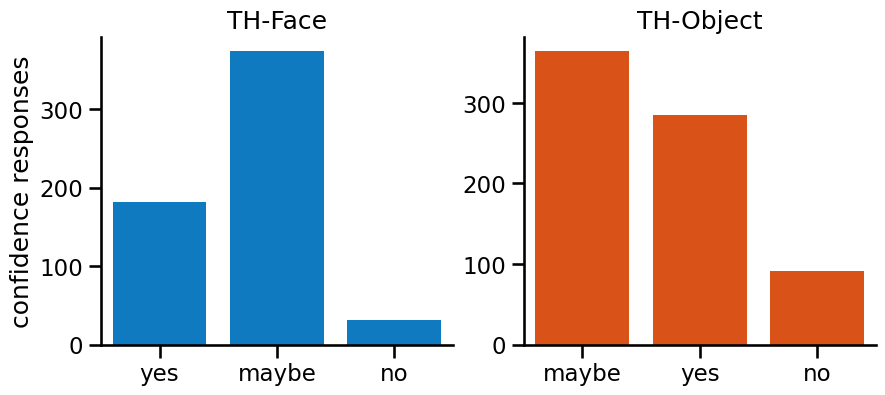

In [22]:
# Plot the confidence response for each task version
ax1, ax2 = make_axes(2, 2, figsize=(10, 4))
plot_bar(conf_thf.values(), labels=conf_thf.keys(),
         ylabel='confidence responses', title='TH-Face', color=colors['face'],  ax=ax1)
plot_bar(conf_tho.values(), labels=conf_tho.keys(),
         title='TH-Object', color=colors['obj'], ax=ax2)
for cax in [ax1, ax2]:
    drop_spines(['top', 'right'], cax)

## Units Checks

Check the unit data.

### Load Data from Unit Results Files

In [23]:
# Load results, for both face and object versions
all_results_face = pd.read_csv(results_path / 'all_results-face.csv')
all_results_obj = pd.read_csv(results_path / 'all_results-object.csv')

### Units Per Task

In [24]:
# Count the total number of units per version
n_units_face = len(all_results_face)
n_units_obj = len(all_results_obj)

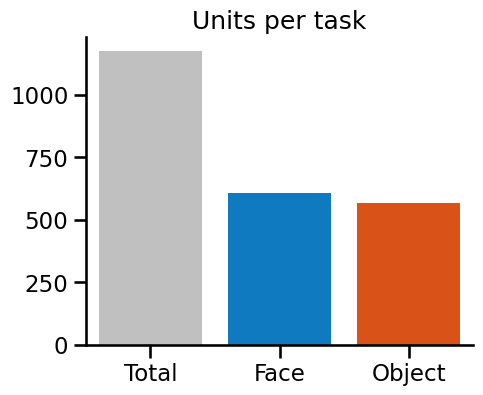

In [25]:
# Plot the number of units in each task
plot_bar([n_units_face + n_units_obj, n_units_face, n_units_obj],
         labels=['Total', 'Face', 'Object'], color=[colors['all'], colors['face'], colors['obj']],
         title='Units per task', figsize=(5, 4))
drop_spines(['top', 'right'])
if SAVE_FIG:
    save_figure('units_task' + SAVE_FTYPE, SAVE_PATH, bbox_inches='tight')

### Units per brain region & hemisphere

In [26]:
# Count the number of units per region & side
region_counts_all = dict(\
    all_results_face['region'].value_counts() + all_results_obj['region'].value_counts())
side_counts_all = dict(\
    all_results_face['side'].value_counts() + all_results_obj['side'].value_counts())

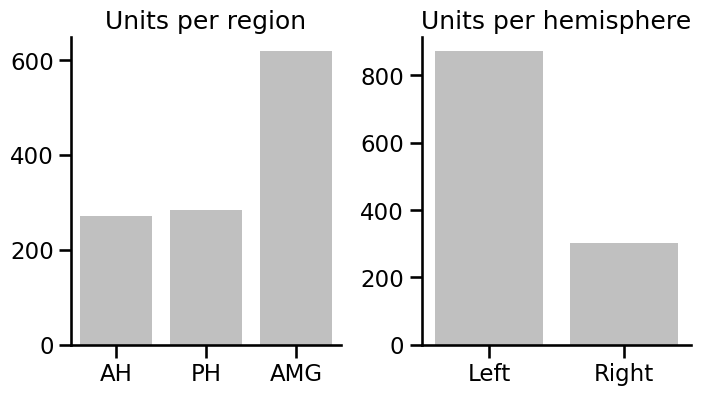

In [27]:
# Plot the number of units per brain region & hemisphere
ax1, ax2 = make_axes(2, 2, figsize=(8, 4), wspace=0.3)
plot_bar([region_counts_all['AH'], region_counts_all['PH'], region_counts_all['AMY']],
         labels=['AH', 'PH', 'AMG'], title='Units per region', color=colors['all'], ax=ax1)
plot_bar([side_counts_all['left'], side_counts_all['right']],
         labels=['Left', 'Right'], title='Units per hemisphere', color=colors['all'], ax=ax2)
for cax in [ax1, ax2]:
    drop_spines(['top', 'right'], cax)
if SAVE_FIG:
    save_figure('units_region' + SAVE_FTYPE, SAVE_PATH, bbox_inches='tight')